<div style="background-color:#2b0000; color:white; padding:25px; border-radius:10px; 
            text-align:center; font-family:'Segoe UI', sans-serif;">

  <h1 style="margin-bottom:8px;"> Cars 4 You 🏎️💨</h1>
  <h3 style="margin-top:0; font-style:italic; font-weight:normal; color:#f05a5a;">
    Auxiliary Notebook – Feature Selection
  </h3>

  <hr style="width:60%; border:1px solid #700000; margin:15px auto;">

  <p style="margin:5px 0; font-size:15px;">
    <b>Group 4</b> - Machine Learning Project (2025/2026)
  </p>
  <p style="margin:0; font-size:13px; color:#e3bdbd;">
    Master in Data Science and Advanced Analytics - Nova Information Management School
  </p>
</div>

<br>

<div style="background-color:#3a0808; color:#f4eaea; padding:15px 20px; border-left:5px solid #700000; 
            border-radius:6px; font-family:'Segoe UI', sans-serif; font-size:14px;">

  <b>Notebook Context</b><br>
  In this auxiliar notebook, we will try to access which columns are important to keep. To do so we will use:

- An independent from training Cross-Validation with 5 folds to ensure that the feature selection is not based on a single split.
  
- To access the feature importance of the columns we will consider the "vote" of many different methods:
  
  - **Filter Methods**: use statistical variance of the data to access importance, without inherent ML algorithms associated. This includes:
    - Removal of constant or *quasi*-constant variables;
    - Correlations between variables.
  
  - **Wrapper Methods**: access importance by creating multiple models with different features and access performance. We will use **Recursive Feature Extraction** on: 
    - Support Vector Regressor;
    - Linear Regressor;
    - Random Forest.

  - **Embedded Methods**: unlike wrapper methods, which use the model's performance as a proxy for feature relevance, embedded methods perform feature selection as part of the model training process itself. We decided to test:
    - Lasso
</div>

<br>

<div style="text-align:center; margin-top:10px;">
  <a href="main.ipynb" 
     style="display:inline-block; background-color:#700000; color:#fff; 
            padding:8px 16px; text-decoration:none; border-radius:6px; 
            font-family:'Segoe UI', sans-serif; font-size:13px;">
     <- Back to Main Notebook
  </a>
</div>

<br>

<div style="text-align:right; font-size:12px; color:#d8bfbf;">
  Last updated: December 2025
</div>


In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Statistics
from scipy.stats import chi2_contingency

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Models
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import PredefinedSplit
import warnings
warnings.filterwarnings('ignore', category=ResourceWarning)
warnings.filterwarnings('ignore', message='.*ResourceTracker.*')

import os

This is the data of our's first fold:

In [2]:
train = pd.read_csv(f"./preprocessing_results/folds/fold_1/train1_step3_processed.csv")
train.head()

,Brand,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,car_age,price_log,model_encoded,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Eletric,fuelType_Hybrid,fuelType_Petrol
0,VW,0.7500,0.203001,0.051724,0.040349,0.322581,0.495026,0.666667,0.0,0.2500,0.658783,0.562600,0,0,1,0,0,0,1
1,Toyota,0.9375,0.032772,0.250000,0.183027,0.241935,0.390149,0.166667,0.0,0.0625,0.575657,0.471642,0,1,0,0,0,0,1
2,Audi,0.9375,0.025879,0.250000,0.155651,0.241935,0.438554,0.666667,0.0,0.0625,0.678576,0.633666,0,0,1,0,0,0,1
3,BMW,0.6250,0.722522,0.051724,0.252640,0.322581,0.583767,0.000000,0.0,0.3750,0.485655,0.594894,0,1,0,1,0,0,0
4,Audi,0.8125,0.152823,0.034483,0.230739,0.225806,0.591835,0.666667,0.0,0.1875,0.602348,0.580000,0,1,0,0,0,0,1


In [3]:
val = pd.read_csv(f"./preprocessing_results/folds/fold_1/validation1_step3_processed.csv")
val.head()

,Brand,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,car_age,price_log,model_encoded,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Eletric,fuelType_Hybrid,fuelType_Petrol
0,BMW,0.9375,0.007136,0.250000,0.163082,0.241935,0.769318,0.500000,0.0,0.0625,0.664173,0.612463,0,1,0,0,0,0,1
1,Audi,0.8125,0.188280,0.250000,0.183027,0.225806,0.228801,0.666667,0.0,0.1875,0.619834,0.623382,1,0,0,0,0,0,1
2,Toyota,1.1875,0.008743,0.250000,0.183027,0.241935,0.607969,0.000000,0.0,-0.1875,0.611832,0.471642,0,1,0,0,0,0,1
3,VW,0.9375,0.121408,0.250000,0.165819,0.241935,0.559565,0.166667,0.0,0.0625,0.656476,0.562600,0,0,1,0,0,0,1
4,Opel,0.8125,0.115758,0.215517,0.196715,0.225806,0.341745,0.166667,0.0,0.1875,0.551588,0.457339,0,1,0,0,0,0,1


In [4]:
num_features = ['year', 'mileage', 'previousOwners', 'mpg', 'engineSize', 'tax', 'paintQuality%', 'hasDamage', 'car_age', 'price_log']
cat_features = ['Brand', 'model', 'fuelType', 'transmission']

# 1. Constant Variables and Impossible Assessment

In [5]:
dropping_columns = []

## 1.1. Constant Variables
The feature `hasDamage`is constant across all folds

In [6]:
variances_list = []

for i in range(1, 6):
    train = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/train{i}_step3_processed.csv")
    variance = train['hasDamage'].var()
    variances_list.append(variance)

np.mean(variances_list, axis=0)

0.0

So should be dropped.

In [7]:
dropping_columns.append('hasDamage')

## 1.2. Impossible Assessment Variables
The feature `paintQuality` is impossible to be assessed by the user and can only be assessed by a mechanic.

In [8]:
dropping_columns.append('paintQuality%')

# 2. Filter Methods

## 2.1. Correlation Analysis

Correlation indices are statistical measures that quantify the strength and direction of the relationship between two variables. They are often used for purpose of this two-fold step:
1. Select **relevant** features - Correlation with the target (the higher the correlation in absolute value, the more relevant the feature seems to be) 
2. Exclude **redundant** features - Correlation between features (the higher the correlation in absolute value, the more redundant the feature).

We have 2 types (numeric and categorical) of variables for this regression task. We choose to evaluate the correlation between them using:
1. For **Numeric & Numeric**: Spearman Correlation
2. For **Categorical & Numeric**: ANOVA, followed 
3. For **Categorical & Categorical** (only for feature redundancy): Cramer-V


In [9]:
def spearman(df, num_features):
    corr_matrix = df[num_features].corr(method='spearman')
    return corr_matrix

In [10]:
def compute_sums_of_squares(df, num_cols, cat_cols):
    """
    Computes ss_between, ss_total, df_between, df_within for each numeric vs categorical pair.
    Returns a nested dict: sums[num_col][cat_col] = (ss_between, ss_total, df_between, df_within)
    """
    sums = {}
    for num_col in num_cols:
        sums[num_col] = {}
        for cat_col in cat_cols:
            values = df[num_col].values
            groups = df[cat_col].values
            y_mean = np.mean(values)
            categories = np.unique(groups)
            
            ss_total = np.sum((values - y_mean)**2)
            ss_between = sum(len(values[groups==cat]) * (np.mean(values[groups==cat]) - y_mean)**2 for cat in categories)
            
            df_between = len(categories) - 1
            df_within = len(values) - len(categories)
            
            sums[num_col][cat_col] = (ss_between, ss_total, df_between, df_within)
    return sums

def compute_f_from_sums(sums):
    """
    Computes F values from sums of squares.
    """
    num_cols = sums.keys()
    cat_cols = next(iter(sums.values())).keys()
    F_df = pd.DataFrame(index=num_cols, columns=cat_cols, dtype=float)
    for num_col in num_cols:
        for cat_col in cat_cols:
            ss_between, ss_total, df_between, df_within = sums[num_col][cat_col]
            ss_within = ss_total - ss_between
            F = (ss_between / df_between) / (ss_within / df_within)
            F_df.loc[num_col, cat_col] = F
    return F_df

def compute_eta_from_sums(sums):
    """
    Computes $\eta^2$ values from sums of squares.
    """
    num_cols = sums.keys()
    cat_cols = next(iter(sums.values())).keys()
    eta_df = pd.DataFrame(index=num_cols, columns=cat_cols, dtype=float)
    
    for num_col in num_cols:
        for cat_col in cat_cols:
            ss_between, ss_total, _, _ = sums[num_col][cat_col]
            eta_sq = ss_between / ss_total
            eta_df.loc[num_col, cat_col] = eta_sq
    return eta_df

In [11]:
def cramers_v(df, cat_features):
    results = pd.DataFrame(index=cat_features, columns=cat_features, dtype=float)
    
    for i, f1 in enumerate(cat_features):
        for f2 in cat_features[i+1:]:
            contingency = pd.crosstab(df[f1], df[f2])
            chi2, _, _, _ = chi2_contingency(contingency)
            n = contingency.sum().sum()
            k = min(contingency.shape)
            
            if n == 0 or k <= 1:
                v = np.nan
            else:
                v = np.sqrt((chi2 / n) / (k - 1))
            
            results.loc[f1, f2] = v
            results.loc[f2, f1] = v
        
        results.loc[f1, f1] = 1.0
    
    return results

In [12]:
def heatmap(matrix, title_name):
    """Plot heatmap"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.title(title_name)
    plt.tight_layout()
    plt.show()

In [13]:
def heatmaps_side_by_side(matrix1, title1, matrix2, title2, figsize=(12,6), squared = True, cmap="coolwarm", width_ratio=(1.5, 1)):
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 2, width_ratios=width_ratio, figure=fig)

    ax0 = fig.add_subplot(gs[0])
    sns.heatmap(matrix1.astype(float), annot=True, fmt=".2f", cmap=cmap, square=squared, ax=ax0) 
    ax0.set_title(title1)

    ax1 = fig.add_subplot(gs[1])
    sns.heatmap(matrix2.astype(float), annot=True, fmt=".2f", cmap=cmap, square=True, ax=ax1)
    ax1.set_title(title2)

    plt.tight_layout()
    plt.show()

In [14]:
num_features_filtered = [col for col in num_features if col not in dropping_columns]

### 2.1.1 Spearman Correlation for Numeric Features
**Spearman's rho ($\rho$)** is a non-parametric statistic that measures the **strength and direction of a monotonic relationship** between two numeric variables.  
It works by converting raw values into **ranks** and then evaluating how similar the rank orders are.
We will use them to compare the correlation of numerical features.

If there are no tied ranks, Spearman's rho is calculated as:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

Where:  
- $n$ — is the number of paired observations  
- $d_i = R(x_i) - R(y_i)$ — is the difference between the ranks of each pair

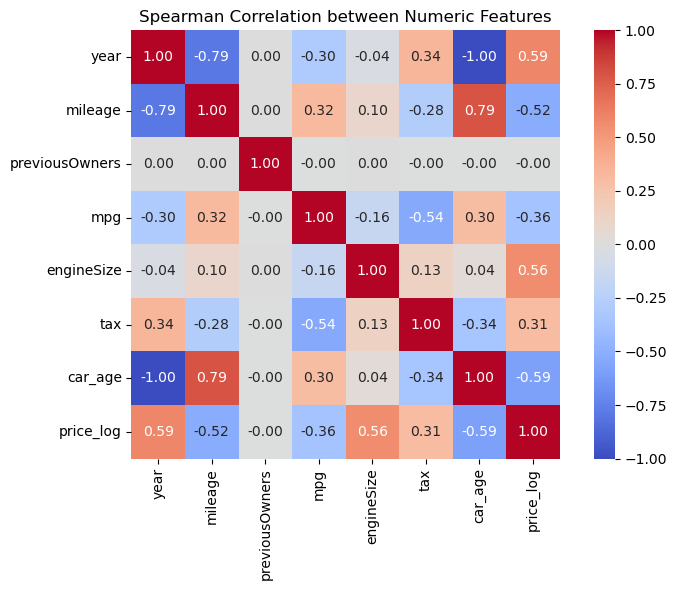

In [15]:
#N sei se devo só usar o train 
corr_matrices = []

for i in range(1, 6):
    train = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/train{i}_step2_featureCreation.csv")
    corr_matrix = spearman(train, num_features_filtered)
    corr_matrices.append(corr_matrix.values)

mean_corr = np.mean(corr_matrices, axis=0)
mean_corr_df = pd.DataFrame(
    mean_corr, 
    index=num_features_filtered, 
    columns=num_features_filtered
)
heatmap(mean_corr_df, "Spearman Correlation between Numeric Features")

Focusing on the price_log row, we can focus on the ones important for the target:

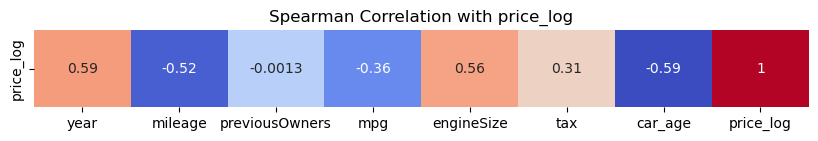

In [16]:
plt.figure(figsize=(10, 1))
sns.heatmap(mean_corr_df[["price_log"]].T, annot=True, cmap="coolwarm", cbar=False)
plt.title("Spearman Correlation with price_log")
plt.show()


Regarding feature redundancy, we need to make some decisions to mitigate multicollinearity:

- `car_age` and `year`, as expected, show the same correlation, since they represent the same thing. One needs to go, we will keep `car_age`.
- `PreviousOwners` will likely be dropped at the end of this analysis, as they show no meaningful correlation with any other feature or the target variable.
- `car_age` and `mileage` has 0.79 of correlation. One of those might be dropped. However, given that **car_age** demonstrates a stronger correlation with the target variable and that its relationships with other predictors are not substantially different from those of `mileage` (seen bellow), it would be reasonable to **retain `car_age` and remove `mileage`** from the model.



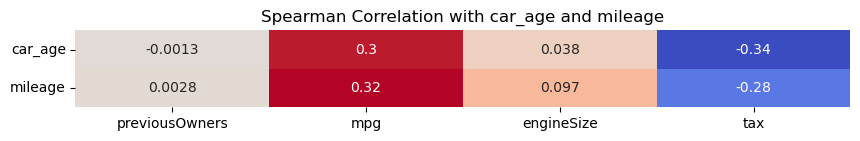

In [17]:
plt.figure(figsize=(10, 1))
sns.heatmap(mean_corr_df.loc[["car_age", "mileage"]].iloc[:, 2:-2], annot=True, cmap="coolwarm", cbar=False)
plt.title("Spearman Correlation with car_age and mileage")
plt.show()


| Predictor          | Spearman           |
| ----------------   | ------------------ |
| `year`             | DROP (redundant)   |
| `mileage`          | DROP?              |
| `tax`              | keep               |
| `mpg`              | keep               |
| `engineSize`       | keep               |
| `previousOwners `  | DROP               |
| `car_age`          | keep               |

### 2.1.2 ANOVA & $\eta^2$ between Numeric and Categorical Features

**ANOVA (Analysis of Variance)** is a statistical method used to test whether there are significant differences between the means of three or more groups.  
When applied to a **numerical variable grouped by a categorical variable**, ANOVA evaluates if the categorical feature has a meaningful relationship with the numerical one.

The **F-statistic** is a **ratio** that compares two types of variability in the data:

$$
F = \frac{\text{Variance between groups}}{\text{Variance within groups}} = \frac{MS_{between}}{MS_{within}}
$$

The **F-statistic** in ANOVA is calculated as:

$$
F = \frac{MS_{between}}{MS_{within}} = \frac{SS_{between} / df_{between}}{SS_{within} / df_{within}}
$$

Where:
- $SS_{between} — sum of squares **between** groups
- $SS_{within}$ — sum of squares **within** groups
- $df_{between} = k - 1$ — degrees of freedom between groups ($k$ = number of groups)
- $df_{within} = n - k$ — degrees of freedom within groups ($n$ = total observations)
- $MS$ — mean square (sum of squares divided by degrees of freedom)

However we didn't want to use ANOVA's **F-statistic** aline because it is **unbounded** (ranges from 0 to $+\infin$, making it hard to compare across different variable pairs and is **heavily dependent on degrees of freedom**, which are directly related to the number of categories and this creates a **bias against categorical variables with many categories**.


#### $\eta^2$ (η²)

To address these limitations, we use **$\eta^2$**, which measures the **proportion of variance** in the numerical variable (dependent) that is explained by the categorical variable (independent).

$$
\eta^2 = \frac{SS_{between}}{SS_{total} = SS_{between} + SS_{within}}
$$

Where:
- $SS_{between} = \sum_{i=1}^{k} n_i (\bar{y}_i - \bar{y})^2$  — variance **between** groups (explained by the categorical variable)
- $SS_{total}= \sum_{j=1}^{n} (y_j - \bar{y})^2$ — **total** variance in the numerical variable

being:
- $n_i$ — number of observations in group $i$
- $\bar{y}_i$ — mean of group $i$
- $\bar{y}$ — overall mean
- $k$ — number of groups (categories)

Unlike the F-statistic, **$\eta^2$** is **bounded between 0 and 1**, just like Pearson or Spearman correlation, making it easier to understand and compare.

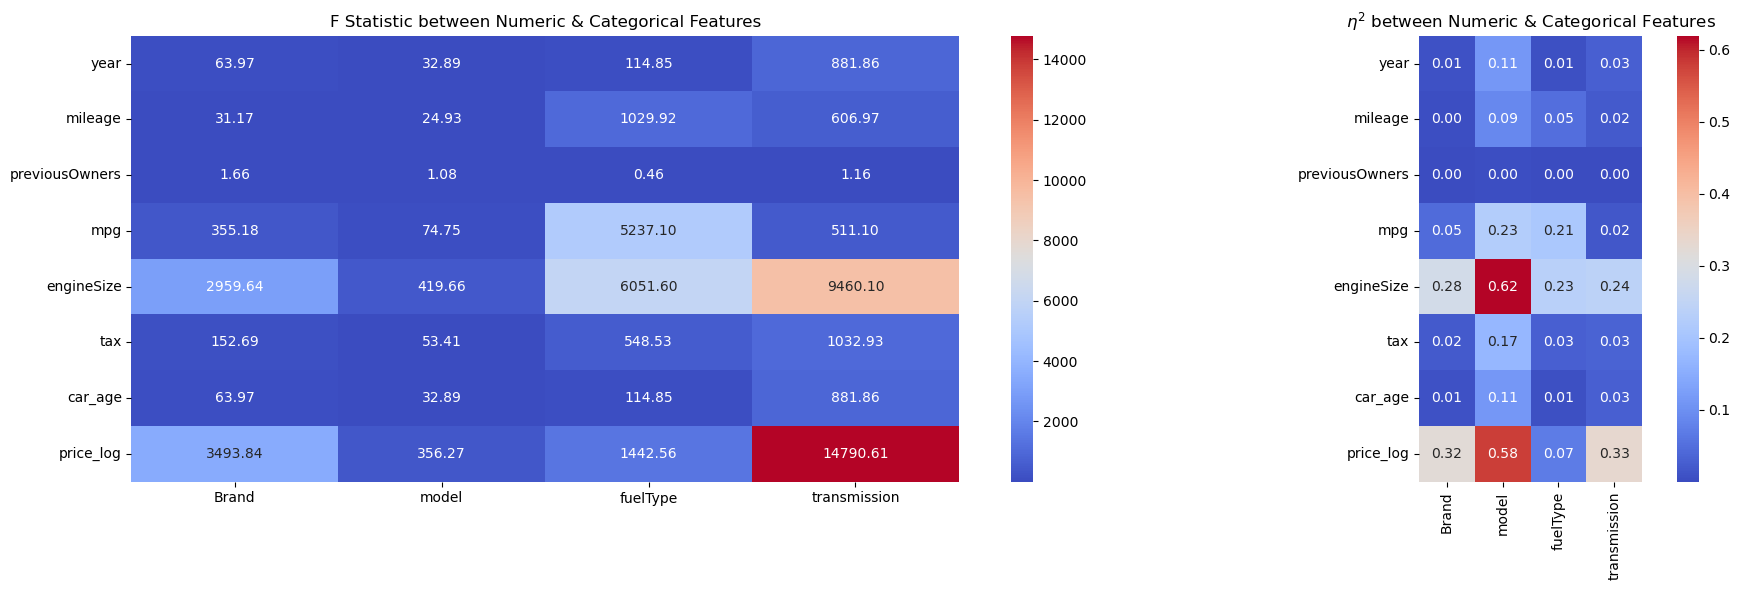

In [18]:
F_matrices = []
eta_matrices = []

for i in range(1, 6):
    train = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/train{i}_step2_featureCreation.csv")
    sums = compute_sums_of_squares(train,num_features_filtered , cat_features)
    
    F_df_fold = compute_f_from_sums(sums)
    eta_df_fold = compute_eta_from_sums(sums)
    
    F_matrices.append(F_df_fold.values)
    eta_matrices.append(eta_df_fold.values)

mean_F = np.mean(F_matrices, axis=0)
mean_eta = np.mean(eta_matrices, axis=0)

F_df = pd.DataFrame(mean_F, index=num_features_filtered, columns=cat_features)
eta_df = pd.DataFrame(mean_eta, index=num_features_filtered, columns=cat_features)

heatmaps_side_by_side(
    F_df, 
    "F Statistic between Numeric & Categorical Features", 
    eta_df, 
    r"$\eta^2$ between Numeric & Categorical Features", 
    (18,6), 
    False
)

- `previousOwners` shows eta square=0.00 across all categorical features, indicating,once again, no meaningful relationships and suggesting potential removal

- $\eta^2$=0.63 indicates `model` explains 63% of `engine size` variance, which makes intuitive sense as different car models have different engine specifications. Moreover, `engineSize` looks to be the one that is best explained by the all categorical variables, while we remember it had almost no correlation with the other numerical features apart from price. 

- $\eta^2$=0.23 between `mpg` and `model` shows model explains 23% of fuel efficiency variance, likely reflecting different engine technologies across models

- `mileage` and `tax` are just explained by the `model`, which seems to be the **best descriminator across all numerical variables**

- `year`/`car_age` show very low $\eta^2$ values (<0.12) with categorical features, suggesting these numeric variables vary independently of `brand`, `model`, `transmission`, or `fuel type`

Focusing on target:


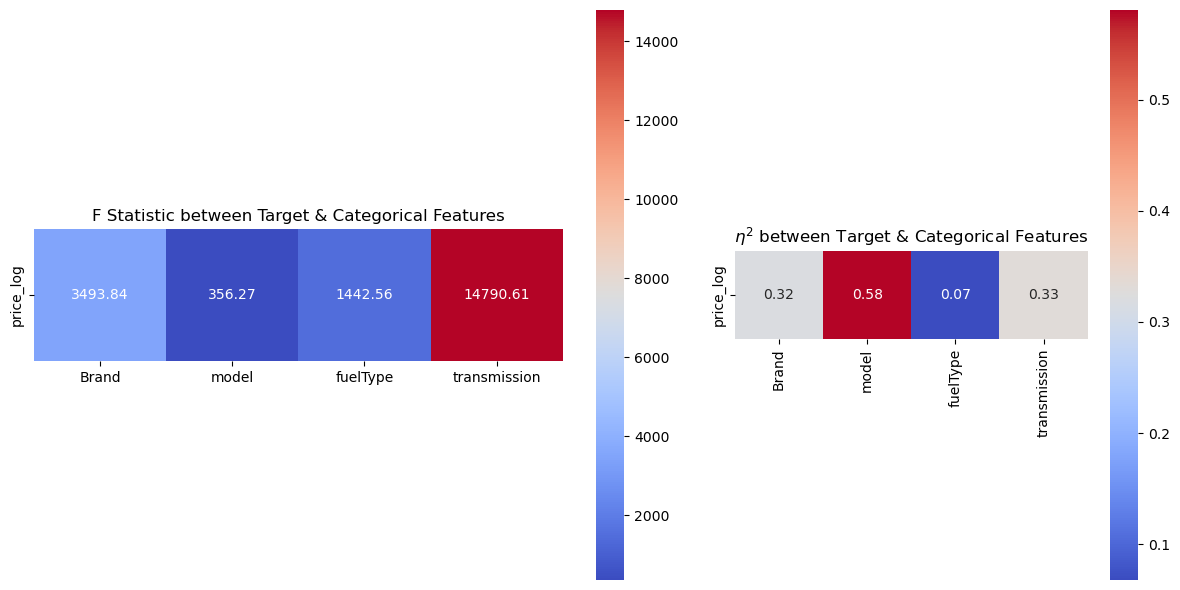

In [19]:
target_f = F_df.loc["price_log"].to_frame().T
target_eta = eta_df.loc["price_log"].to_frame().T

heatmaps_side_by_side(target_f, "F Statistic between Target & Categorical Features", target_eta, r"$\eta^2$ between Target & Categorical Features")

- `transmission` shows much higher F-statistic (14296) than `model` (350), yet `model` explains 76% more variance (η²=0.58 vs 0.33). This demonstrates why F-statistics are misleading when comparing features with different cardinalities (3 vs 190 categories)
- `model` ($\eta^2$=0.58) — explains 58% of price variance
- `transmission` ($\eta^2$=0.33) — explains 33% of price variance  
- `Brand` ($\eta^2$=0.32) — explains 32% of price variance
- `fuelType` ($\eta^2$=0.07) — weak effect, only 7% variance explained. Might be dropped

| Predictor          | $\eta^2$           |
| ----------------   | ------------------ |
| `year`             | keep               |
| `mileage`          | keep               |
| `tax`              | keep               |
| `mpg`              | keep               |
| `engineSize`       | keep               |
| `previousOwners `  | DROP               |
| `car_age`          | keep               |
| `Brand`            | keep               | 
| `model`            | keep               | 
| `transmission`     | keep               |
| `fuelType`         | DROP?              | 


### 2.1.3 Recap: Features against the target

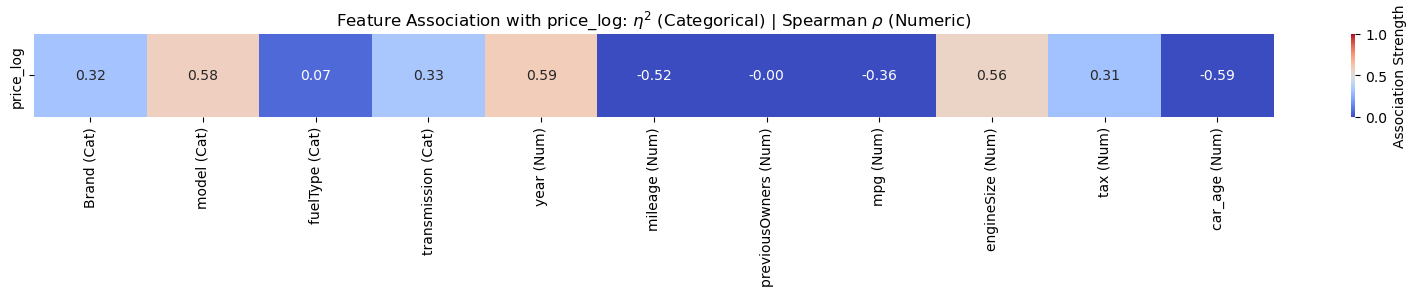

In [20]:
target_eta.columns = [f"{col} (Cat)" for col in target_eta.columns]

spearman_numeric = mean_corr_df[["price_log"]].T.drop("price_log", axis=1)
spearman_numeric.columns = [f"{col} (Num)" for col in spearman_numeric.columns]

combined = pd.concat([target_eta, spearman_numeric], axis=1)

plt.figure(figsize=(20, 1.5))
sns.heatmap(combined, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, 
            cbar_kws={'label': 'Association Strength'})
plt.title(r"Feature Association with price_log: $\eta^2$ (Categorical) | Spearman $\rho$ (Numeric)")
plt.xlabel("")
plt.subplots_adjust(bottom=0.2, top=0.75) 
plt.show()

As a summary of all variables against the target:


The **highest rankers** are:
- `car_age`/`year`- 60%
- `model` - 58%
- `engine_size` - 56%
- `mileage`- 52%

The **lowest rankers** are:
- `previousOwners`- 0%
- `fuelType`- 7%

### 1.1.4 Cramér's V between Categorical Features

**Cramér's V** is a measure of association between two **categorical variables**. It is based on the chi-squared ($\chi^2$) statistic and normalizes it to a 0–1 scale, making it comparable across different contingency table sizes.  
We use it to assess correlation between categorical features.

#### 1. $\chi^2$ Test (Significance Test)
- **Objective:** Test the null hypothesis of **independence** between two categorical variables.  

$$
\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}
$$

Where:
- $O_i$ = observed counts  
- $E_i$ = expected counts under independence  

#### 2. Cramér’s V (Normalized $\chi^2$)
- **Objective:** Measure the **strength of association** between two categorical variables.  
- **Formula:**

$$
V = \sqrt{\frac{\chi^2}{n * \min(k_\text{rows}-1, k_\text{cols}-1)}}
$$

Where:
- $n$ = total number of observations  
- $k_\text{rows}$, $k_\text{cols}$ = number of categories in each variable  

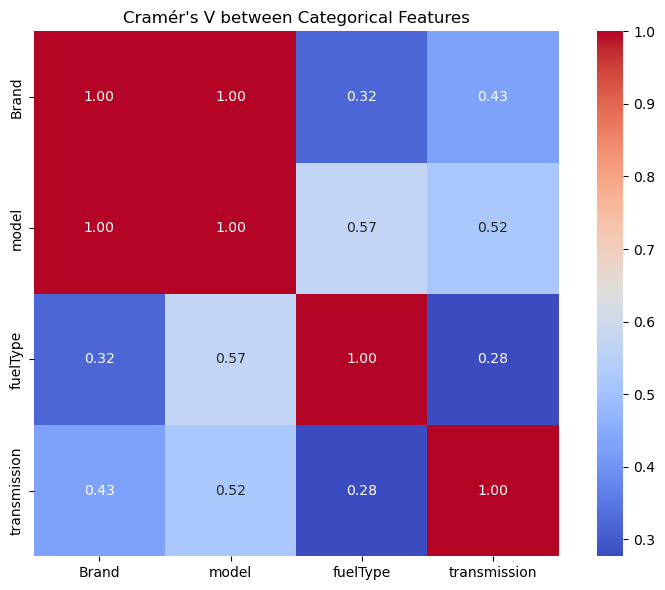

In [21]:
# Calcular Cramér's V para cada fold
cramers_matrices = []

for i in range(1, 6):
    train = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/train{i}_step2_featureCreation.csv")
    cramers_matrix = cramers_v(train, cat_features)
    cramers_matrices.append(cramers_matrix.values)

# Média das matrizes de Cramér's V
mean_cramers = np.mean(cramers_matrices, axis=0)

# Converter para DataFrame
cat_cat_corr = pd.DataFrame(
    mean_cramers,
    index=cat_features,
    columns=cat_features
)

heatmap(cat_cat_corr, "Cramér's V between Categorical Features")

The Cramér’s V analysis indicates a **perfect association between `Brand` and `Model` (1.00)**, meaning these two variables are **redundant**. This was expected since all car with the same model are part of the same brand. 
- In such cases, it is preferable to **retain `Model`** and **remove `Brand`**, since the model name inherently contains information about the brand. 
- Comparing `Brand`/`model`against `fuelType`and `transmission`, `model` shows a stronger correlation with the other two also indicating is a stronger discriminator
- `fuelType`and `transmission` have a very weak correlation

| Predictor      |  Cramér V | 
| -------------- |  -------- | 
| `Brand`        |  DROP     | 
| `model`        |  keep     | 
| `transmission` |  keep     | 
| `fuelType`     |  keep     | 


# 3. Wrapper Methods

Recursive Feature Elimination (RFE) is a wrapper-based feature selection technique that iteratively trains a model and removes the least important features until the desired number of features is reached. It helps identify the most relevant predictors based on model performance.

To ensure better generalization and stability of the selected features, we will apply RFE across five folds of the dataset, evaluating consistency of feature importance across different training subsets.

We will use three models for this process:

* **Support Vector Machines (SVMs)**
* **Logistic Regressors**
* **Random Forests**

These models are chosen to capture different aspects of the data — linear, probabilistic, and ensemble-based relationships.


As metrics, we will use **MAE** and **MSE**, which balance different aspects of model performance:

- **MAE (Mean Absolute Error):** Measures the average absolute difference between predicted and actual values. It gives a clear idea of how far predictions are from reality, in the same units as the target. 

- **RMSE (Root Mean Squared Error):** Measures the square root of the average squared differences between predicted and actual values. RMSE penalizes larger errors more heavily than MAE. 

Together, these metrics provide a **balanced view of model performance**, capturing absolute errors, squared errors, variance explanation, and relative percentage error.

## 3.1. RFE Utils

We will use normal RFE with LinearRegression and Support Vector Regressor on all possible number of features to select to observe the performance.
Then we will use RFECV to find the optimal number of features for each model and compare the two approaches.
Finally we will run a Random Forest Regressor with RFE with the best number of features found previously to access the best features.

In [22]:
def run_rfe(model, X_train, y_train, n_features_to_select=None):
    X_train = X_train.copy()
    
    if n_features_to_select is None:
        n_features_to_select = max(1, int(X_train.shape[1] / 2))
    
    selector = RFE(model, n_features_to_select=n_features_to_select)
    selector.fit(X_train, y_train)
    
    selected_features = X_train.columns[selector.support_]
    
    return selector, selected_features

In [23]:
def run_rfe_cv(model, X_train, y_train, X_val, y_val, scoring='neg_mean_squared_error', min_features_to_select=1):
    X_combined = pd.concat([X_train, X_val], axis=0).copy()
    y_combined = np.concatenate([y_train, y_val])
    
    test_fold = [-1] * len(X_train) + [0] * len(X_val)
    
    
    ps = PredefinedSplit(test_fold=test_fold)
    
    selector = RFECV(
        estimator=model,
        step=1,  
        cv=ps,  
        scoring=scoring,
        min_features_to_select=min_features_to_select,
        n_jobs=-1  #   
    )
    
    # Fit the selector
    selector.fit(X_combined, y_combined)
    
    # Get selected features
    selected_features = X_combined.columns[selector.support_]
    
    return selector, selected_features

In [24]:
def get_svr():
    return SVR(kernel='linear')  
    
def get_linear_regressor():
    return LinearRegression()

def get_random_forest():
    return RandomForestRegressor(n_estimators=100, random_state=42)


In [25]:
def plot_rfe_results(results): 
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes = axes.flatten()

    for idx, (model_name, folds) in enumerate(results.items()):
        n_features = folds[0]["n_features_range"]
        
        train_mse_mean = np.mean([f["train_mse"] for f in folds], axis=0)
        val_mse_mean = np.mean([f["val_mse"] for f in folds], axis=0)
        train_mae_mean = np.mean([f["train_mae"] for f in folds], axis=0)
        val_mae_mean = np.mean([f["val_mae"] for f in folds], axis=0)

        ax = axes[idx]
        
        ax2 = ax.twinx()
        
        line1 = ax.plot(n_features, train_mse_mean, label="Training MSE", 
                        marker='o', color='blue', linestyle='-')
        line2 = ax.plot(n_features, val_mse_mean, label="Validation MSE", 
                        marker='s', color='cornflowerblue', linestyle='--')
        
        line3 = ax2.plot(n_features, train_mae_mean, label="Training MAE", 
                         marker='o', color='red', linestyle='-')
        line4 = ax2.plot(n_features, val_mae_mean, label="Validation MAE", 
                         marker='s', color='lightcoral', linestyle='--')
        
        min_idx = np.argmin(val_mse_mean)
        min_n_features = n_features[min_idx]
        ax.axvline(x=min_n_features, color='green', linestyle=':', 
                   linewidth=2, label=f'Min Val MSE ({min_n_features} features)')
        
        ax.set_xlabel("Number of features")
        ax.set_ylabel("MSE", color='blue')
        ax2.set_ylabel("MAE", color='red')
        ax.set_title(f"{model_name} - MSE & MAE")
        
        ax.tick_params(axis='y', labelcolor='blue')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Combinar legendas
        lines = line1 + line2 + line3 + line4
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='best')
        
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [26]:
def get_scores(model, selector, selected_features, X_train, y_train, X_valid, y_valid):
    X_train_rfe = selector.transform(X_train)
    X_valid_rfe = selector.transform(X_valid)

    print(f"Selected features: {list(selected_features)}")
    model.fit(X_train_rfe, y_train)
    
    # Fazer predições
    y_train_pred = model.predict(X_train_rfe)
    y_valid_pred = model.predict(X_valid_rfe)
    
    # Calcular MSE e MAE
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)
    
    print(f"Train MSE: {train_mse:.4f} | Train MAE: {train_mae:.4f}")
    print(f"Validation MSE: {valid_mse:.4f} | Validation MAE: {valid_mae:.4f}")
    
    return train_mse, train_mae, valid_mse, valid_mae

In [27]:
target_col='price_log'

In [28]:
models = {
    "Linear Regression": get_linear_regressor,
    "Support Vector Regressor": get_svr,
}

In [29]:
models_cv = {
    "Linear Regression": get_linear_regressor,
    "Support Vector Regressor": get_svr,
    "Random Forest Regressor": get_random_forest
}

In [30]:
dropping_columns.append('Brand')
dropping_columns.append('year')

## 3.2. RFE 
Here, we will try a Linear Regression and a Support Vector Regressor with all possible number of features and assess the $R^2$

In [31]:
def main_rfe_pipeline(target_col):
    
    results = {name: [] for name in models.keys()}
    
    for i in range(1, 6): 
        print(f"\n=== Fold {i} ===")
        
        train = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/train{i}_step3_processed.csv")
        validation = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/validation{i}_step3_processed.csv")

        X_train = train.drop(columns=[target_col] + dropping_columns)
        y_train = train[target_col]

        X_valid = validation.drop(columns=[target_col] + dropping_columns)
        y_valid = validation[target_col]

        for name, model_name in models.items():

            print(f"\nModel: {name}")
            
            nof_list = np.arange(1, X_train.shape[1] + 1) 
            lowest_mse = float('inf')  
            best_number_of_features = 0  
            train_mse_list = []
            train_mae_list = []
            val_mse_list = []
            val_mae_list = []
            selected_features_list = []
            
            for n in nof_list:
                print(f"\nNumber of features: {n}")
                model = model_name()
                selector, selected_features = run_rfe(
                    model=model, 
                    X_train=X_train, 
                    y_train=y_train,
                    n_features_to_select=n)
                
                train_mse, train_mae, valid_mse, valid_mae = get_scores(model, selector, selected_features, X_train, y_train, X_valid, y_valid)

                selected_features_list.append(selected_features)
                train_mse_list.append(train_mse)
                train_mae_list.append(train_mae)
                val_mse_list.append(valid_mse)
                val_mae_list.append(valid_mae)

                if valid_mse < lowest_mse:
                    lowest_mse = valid_mse
                    best_number_of_features = n
            print("\n--- Summary ---")
            print(f"Optimum number of features: {best_number_of_features}")
            print(f"Best MSE with {best_number_of_features} features: {lowest_mse:.4f}")
            
            selected_features_best = selected_features_list[best_number_of_features - 1]
                
            results[name].append({
                "fold": i,
                "n_features_range": list(nof_list),
                "train_mse": train_mse_list,
                "train_mae": train_mae_list,
                "val_mse": val_mse_list,
                "val_mae": val_mae_list,
                "best_n_features": best_number_of_features,
                "best_val_mse": lowest_mse,
                "selected_features": selected_features_best,
                "all_selected_features": selected_features_list,
            })
    
    return results

In [32]:
results = main_rfe_pipeline(target_col=target_col)
os.makedirs("feature_selection_results", exist_ok=True)
df_results = pd.DataFrame(results)
df_results.to_csv("feature_selection_results/rfe.csv", index=False)


=== Fold 1 ===

Model: Linear Regression

Number of features: 1
Selected features: ['model_encoded']
Train MSE: 0.0037 | Train MAE: 0.0438
Validation MSE: 0.0035 | Validation MAE: 0.0433

Number of features: 2
Selected features: ['car_age', 'model_encoded']
Train MSE: 0.0014 | Train MAE: 0.0273
Validation MSE: 0.0015 | Validation MAE: 0.0276

Number of features: 3
Selected features: ['engineSize', 'car_age', 'model_encoded']
Train MSE: 0.0012 | Train MAE: 0.0253
Validation MSE: 0.0013 | Validation MAE: 0.0255

Number of features: 4
Selected features: ['mileage', 'engineSize', 'car_age', 'model_encoded']
Train MSE: 0.0009 | Train MAE: 0.0227
Validation MSE: 0.0010 | Validation MAE: 0.0229

Number of features: 5
Selected features: ['mileage', 'engineSize', 'car_age', 'model_encoded', 'fuelType_Eletric']
Train MSE: 0.0009 | Train MAE: 0.0227
Validation MSE: 0.0010 | Validation MAE: 0.0229

Number of features: 6
Selected features: ['mileage', 'mpg', 'engineSize', 'car_age', 'model_encoded

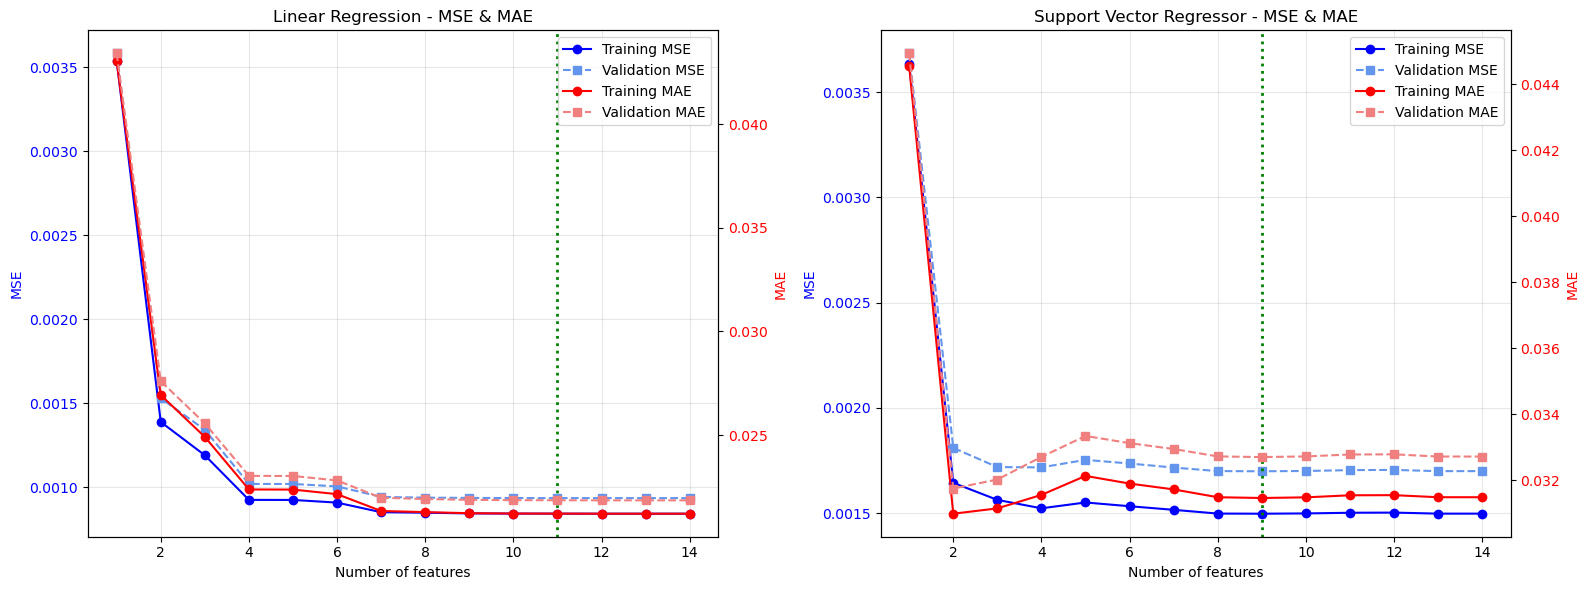

In [33]:
plot_rfe_results(results)

After averaging MSE and MAE across all folds and ploting, we conclude that the best number of features on average for a **Linear Regression** is 11 and for a **Support Vector Regression** is 9
A **Linear Regression** with 11 chooses:
- `mileage`
- `mpg`
- `engineSize`
- `car_age`
- `model_encoded`
- `transmission_Manual`
- `transmission_Semi_Auto`
- `fuelType_Diesel`
- `fuelType_Petrol`
- `fuelType_Eletric`

A **Support Vector Regression** with 9 features chooses:
- `engineSize`
- `model_encoded`
- `mileage`
- `mpg`
- `tax`
- `car_age`
- `transmission_Manual`
- `transmission_Semi-Auto`
- `fuelType_Hybrid` 


A more in depth analysis will be done after running the same models plus a Random Forest with RFECV.

## 3.3. RFECV
Here we will use the Linear Regression and The Support Vector Regressor to prove the previous experiment right and we will add Random Forest which is more robust.

In [34]:
def main_rfecv_pipeline(target_col,scoring='neg_mean_squared_error'):
    
    results = {name: [] for name in models_cv.keys()}
    
    for i in range(1, 6): 
        print(f"\n=== Fold {i} ===")
        
        train = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/train{i}_step3_processed.csv")
        validation = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/validation{i}_step3_processed.csv")

        X_train = train.drop(columns=[target_col] + dropping_columns)
        y_train = train[target_col]

        X_valid = validation.drop(columns=[target_col] + dropping_columns)
        y_valid = validation[target_col]
        
        for name, model_name in models_cv.items():
            model = model_name()
            print(f"\nModel: {name}")
            
            selector, selected_features = run_rfe_cv(
                model=model,
                X_train=X_train,
                X_val=X_valid,
                y_train=y_train,
                y_val= y_valid,
                scoring=scoring,
                min_features_to_select=1
            )
            
            best_n_features = selector.n_features_
            print(f"Optimal number of features: {best_n_features}")
            
            train_mse, train_mae, valid_mse, valid_mae = get_scores(
                model, selector, selected_features, X_train, y_train, X_valid, y_valid
            )
            
            results[name].append({
                "fold": i,
                "best_n_features": best_n_features,
                "train_mse": train_mse,
                "train_mae": train_mae,
                "val_mse": valid_mse,
                "val_mae": valid_mae,
                "selected_features": list(selected_features),
                "feature_rankings": selector.ranking_.tolist(),
            })
    
    return results

In [35]:
results = main_rfecv_pipeline(target_col=target_col)
df_results = pd.DataFrame(results)
df_results.to_csv("feature_selection_results/rfecv.csv", index=False)


=== Fold 1 ===

Model: Linear Regression
Optimal number of features: 8
Selected features: ['mileage', 'mpg', 'engineSize', 'car_age', 'model_encoded', 'transmission_Manual', 'fuelType_Diesel', 'fuelType_Eletric']
Train MSE: 0.0009 | Train MAE: 0.0215
Validation MSE: 0.0009 | Validation MAE: 0.0218

Model: Support Vector Regressor
Optimal number of features: 8
Selected features: ['mileage', 'tax', 'mpg', 'engineSize', 'car_age', 'model_encoded', 'transmission_Manual', 'fuelType_Hybrid']
Train MSE: 0.0015 | Train MAE: 0.0321
Validation MSE: 0.0017 | Validation MAE: 0.0327

Model: Random Forest Regressor
Optimal number of features: 11
Selected features: ['mileage', 'tax', 'mpg', 'engineSize', 'previousOwners', 'car_age', 'model_encoded', 'transmission_Automatic', 'transmission_Manual', 'fuelType_Diesel', 'fuelType_Petrol']
Train MSE: 0.0001 | Train MAE: 0.0052
Validation MSE: 0.0004 | Validation MAE: 0.0140

=== Fold 2 ===

Model: Linear Regression
Optimal number of features: 14
Selected

This confirms our expectations from the systematic RFE:

**Linear Regression** maintains its best performance with validation MAE between 0.0218 and 0.0219 and validation MSE between 0.0009 and 0.0010 across all folds, selecting between 8 and 14 features depending on the fold.

The features that appear across all folds are:
- `mileage`
- `mpg`
- `engineSize`
- `car_age`
- `model_encoded`
- `transmission_Manual`
- `fuelType_Diesel`
- `fuelType_Eletric`

The features that appear in most folds are:
- `fuelType_Petrol` (4/5 folds)
- `transmission_Semi-Auto` (4/5 folds)
- `tax` (3/5 folds)
- `transmission_Automatic` (3/5 folds)

Features appearing occasionally:
- `previousOwners` (1/5 folds)
- `fuelType_Hybrid` (1/5 folds)

**Support Vector Regressor** has validation MAE between 0.0264 and 0.0327 and validation MSE between 0.0014 and 0.0017, performing worse than LR. It selected between 3 and 10 features, achieving its best performance (validation MAE: 0.0264-0.0267, validation MSE: 0.0014) with just 3 features in folds 2 and 5.

The features that appear across all folds are:
- `engineSize`
- `car_age`
- `model_encoded`

Features appearing frequently:
- `mileage` (3/5 folds)
- `mpg` (3/5 folds)
- `tax` (3/5 folds)
- `transmission_Manual` (3/5 folds)
- `fuelType_Hybrid` (3/5 folds)

Other features:
- `transmission_Semi-Auto` (2/5 folds)
- `transmission_Automatic` (1/5 folds)

**Random Forest Regressor** has the best performance with validation MAE between 0.0139 and 0.0142 and validation MSE between 0.0004 and 0.0005, significantly outperforming both LR and SVR. It consistently selected between 11 and 13 features across all folds.

The features that appear across all folds are:
- `mileage`
- `tax`
- `mpg`
- `engineSize`
- `previousOwners`
- `car_age`
- `model_encoded`
- `transmission_Automatic`
- `transmission_Manual`
- `fuelType_Diesel`
- `fuelType_Petrol`

Features appearing in most folds:
- `transmission_Semi-Auto` (4/5 folds)
- `fuelType_Hybrid` (3/5 folds)

### **Numerical Variables**
| Predictor          | RFE (Linear Regression) | RFE (Support Vector Regressor) | RFE (Random Forest) | Conclusion |
|--------------------|-------------------------|--------------------------------|---------------------|------------|
| `year`             | ALREADY DROPPED         | ALREADY DROPPED                | ALREADY DROPPED     | DROP       |
| `mileage`          | keep (5/5)              | keep (3/5)                     | keep (5/5)          | **keep**   |
| `tax`              | keep (3/5)              | keep (3/5)                     | keep (5/5)          | **keep**   |
| `mpg`              | keep (5/5)              | keep (3/5)                     | keep (5/5)          | **keep**   |
| `engineSize`       | keep (5/5)              | keep (5/5)                     | keep (5/5)          | **keep**   |
| `previousOwners`   | keep (1/5)              | DROP (0/5)                     | keep (5/5)          | **keep**   |
| `car_age`          | keep (5/5)              | keep (5/5)                     | keep (5/5)          | **keep**   |

**Note 1:** Notation (X/5) means in X out of 5 folds, the model kept the variable.

**Note 2:** `year` was already dropped before RFE because it was redundant with `car_age`. This prevents multicollinearity that could negatively impact model stability, interpretability, and feature importance rankings.

**Note 3:** Features consistently selected across all 5 folds by at least 2 out of 3 models are considered strong candidates for retention.


### **Categorical Variables**
| Predictor                  | RFE (Linear Regression) | RFE (Support Vector Regressor) | RFE (Random Forest) | Conclusion |
|----------------------------|-------------------------|--------------------------------|---------------------|------------|
| `Brand`                    | ALREADY DROPPED         | ALREADY DROPPED                | ALREADY DROPPED     | DROP       |
| `model_encoded`            | keep (5/5)              | keep (5/5)                     | keep (5/5)          | **keep**   |
| `transmission_Automatic`   | keep (3/5)              | keep (1/5)                     | keep (5/5)          | **keep**   |
| `transmission_Manual`      | keep (5/5)              | keep (3/5)                     | keep (5/5)          | **keep**   |
| `transmission_Semi-Auto`   | keep (4/5)              | keep (2/5)                     | keep (4/5)          | **keep**   |
| `fuelType_Diesel`          | keep (5/5)              | DROP (0/5)                     | keep (5/5)          | **keep**   |
| `fuelType_Eletric`         | keep (5/5)              | DROP (0/5)                     | DROP (0/5)          | **keep**   |
| `fuelType_Hybrid`          | keep (1/5)              | keep (3/5)                     | keep (3/5)          | **keep**   |
| `fuelType_Petrol`          | keep (4/5)              | DROP (0/5)                     | keep (5/5)          | **keep**   |

# 4. Embedded Methods

Embedded methods perform feature selection during the model training process by incorporating regularization penalties that shrink or eliminate coefficients of irrelevant features. Unlike wrapper methods, they are computationally efficient as feature selection happens simultaneously with model fitting.

To ensure robust evaluation and generalization, we will apply embedded regularization methods across five folds of the dataset

We used **LASSO Regression (L1)** which Performs automatic feature selection by setting irrelevant coefficients to exactly zero, producing sparse models


In [36]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

## 4.1 LASSO

LASSO (Least Absolute Shrinkage and Selection Operator) is a linear regression model that incorporates $L_1$ regularization to perform both regularization and automatic feature selection. It minimizes the following objective function:

$$
\min_{\beta_0,\dots,\beta_p} \frac{1}{2n}\sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p} |\beta_j|,
$$

where $\lambda \geq 0$ is the regularization parameter that controls the strength of the penalty.

The objective function consists of two components:
1. **Loss term**: measures the fit to the training data (residual sum of squares)
2. **Regularization term**: $\lambda \sum_{j=1}^{p} |\beta_j|$ penalizes the absolute values of the coefficients

The key property of LASSO is that the $L_1$ penalty can drive some coefficients exactly to zero when $\lambda$ is sufficiently large. This performs **automatic feature selection** during training, identifying and retaining only the most important predictors while eliminating irrelevant ones. By shrinking coefficients and reducing model complexity, LASSO effectively reduces overfitting and improves generalization.

In [37]:
def lasso_pipeline(target_col, random_state=42):
    results = []

    for i in range(1, 6):
        print(f"\n=== Fold {i} ===")
        
        # Load data
        train = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/train{i}_step3_processed.csv")
        validation = pd.read_csv(f"./preprocessing_results/folds/fold_{i}/validation{i}_step3_processed.csv")

        # Prepare train data
        X_train = train.drop(columns=[target_col] + dropping_columns)
        y_train = train[target_col]

        # Prepare validation data
        X_valid = validation.drop(columns=[target_col] + dropping_columns)
        y_valid = validation[target_col]

        # Combine train and validation datasets
        X_combined = pd.concat([X_train, X_valid], axis=0).copy()
        y_combined = np.concatenate([y_train, y_valid])
        
        # Create test fold index (-1 for train, 0 for validation)
        test_fold = [-1] * len(X_train) + [0] * len(X_valid)
                
        # Define the PredefinedSplit
        ps = PredefinedSplit(test_fold=test_fold)
        
        # Fit LassoCV with PredefinedSplit
        lasso = LassoCV(
            cv=ps, 
            random_state=random_state,
            n_jobs=-1,
            max_iter=10000
        )
        lasso.fit(X_combined, y_combined)
        
        # Predict on validation set
        y_pred = lasso.predict(X_valid)
        
        # Calculate metrics
        mse = mean_squared_error(y_valid, y_pred)
        mae = mean_absolute_error(y_valid, y_pred)
        
        # Get selected features (non-zero coefficients)
        selected_features = X_train.columns[lasso.coef_ != 0].tolist()
        n_selected = len(selected_features)
        
        print(f"Optimal alpha: {lasso.alpha_:.6f}")
        print(f"Number of selected features: {n_selected}/{len(X_train.columns)}")
        print(f"Validation MSE: {mse:.4f}")
        print(f"Validation MAE: {mae:.4f}")
        print(f"Selected features: {selected_features}\n")

        results.append({
            "fold": i,
            "alpha": lasso.alpha_,
            "n_features_selected": n_selected,
            "selected_features": selected_features,
            "coef": lasso.coef_,
            "mse": mse,
            "mae": mae,
        })
    
    return results


=== Fold 1 ===
Optimal alpha: 0.000079
Number of selected features: 9/14
Validation MSE: 0.0009
Validation MAE: 0.0218
Selected features: ['mileage', 'mpg', 'engineSize', 'car_age', 'model_encoded', 'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 'fuelType_Hybrid']


=== Fold 2 ===
Optimal alpha: 0.000039
Number of selected features: 9/14
Validation MSE: 0.0010
Validation MAE: 0.0218
Selected features: ['mileage', 'mpg', 'engineSize', 'car_age', 'model_encoded', 'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 'fuelType_Hybrid']


=== Fold 3 ===
Optimal alpha: 0.000048
Number of selected features: 9/14
Validation MSE: 0.0009
Validation MAE: 0.0219
Selected features: ['mileage', 'mpg', 'engineSize', 'car_age', 'model_encoded', 'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 'fuelType_Hybrid']


=== Fold 4 ===
Optimal alpha: 0.000042
Number of selected features: 9/14
Validation MSE: 0.0010
Validation MAE: 0.0218
Selected feature

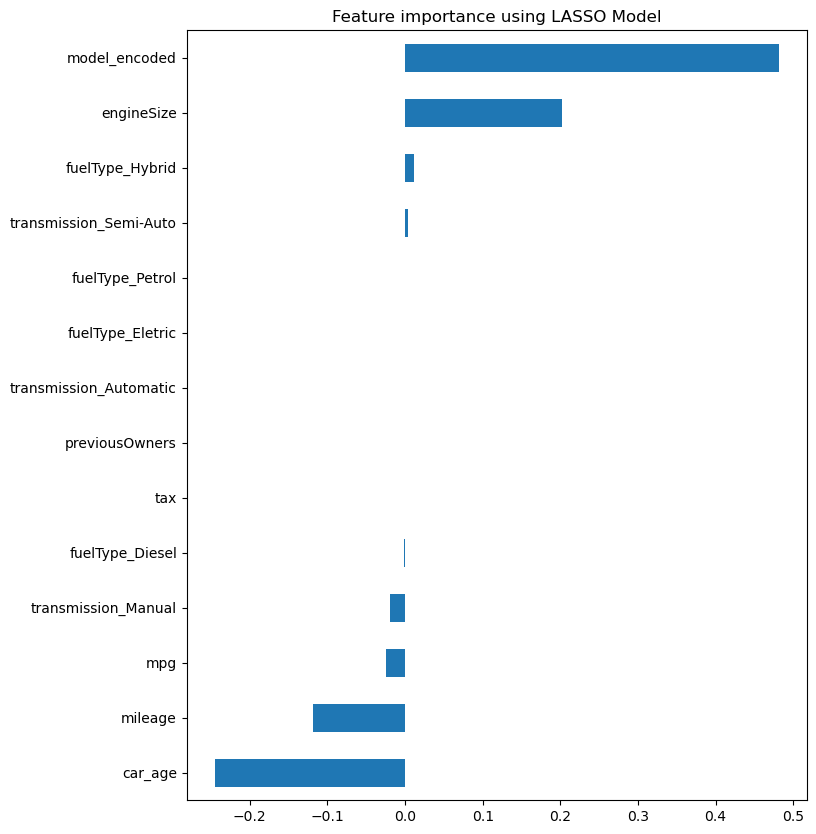

In [38]:
results = lasso_pipeline(target_col='price_log')

train_sample = pd.read_csv(f"./preprocessing_results/folds/fold_1/train1_step3_processed.csv", index_col=0)

cols_to_drop = ['price_log'] + [col for col in dropping_columns if col in train_sample.columns]
X_sample = train_sample.drop(columns=cols_to_drop)
feature_names = X_sample.columns.tolist()

coef_df = pd.DataFrame(
    [r['coef'] for r in results], 
    columns=feature_names
)

plot_importance(coef_df.mean(), "LASSO")

We can observe `model` is by far the most significant variable, followed by `engineSize`, `mileage`, `car_age`, `mpg`, `tax`. Manual `transmission` and Hybrid `fuelType`, but all the other seem irrelevant.
LASSO choosed always the same 9 features (only dropped the 4 with 0 relevance):
- `mileage`
- `mpg`
- `engineSize`
- `car_age` 
- `model_encoded` 
- `transmission_Manual`
- `transmission_Semi-Auto`
- `fuelType_Diesel`
- `fuelType_Hybrid`


### **Numerical Variables**

| Predictor          | Lasso Regression          |
| ------------------ | ----------------          |
| `year`             |  ALREADY DROPPED          |
| `mileage`          |  keep                     |
| `tax`              |  DROP                     |
| `mpg`              |  keep                     |
| `engineSize`       |  keep                     |
| `previousOwners`   |  DROP                     |
| `car_age`          |  keep                     |

### **Categorical Variables**

| Predictor                  |   Lasso Regression      |
|----------------------------|-------------------------|
| `Brand`                    | ALREADY DROPPED         | 
| `model`                    | keep                    | 
| `transmission_Automatic`   | DROP                    | 
| `transmission_Manual`      | keep                    | 
| `transmission_Semi-Auto`   | keep                    |
| `fuelType_Diesel`          | keep                    | 
| `fuelType_Eletric`         | DROP.                   |
| `fuelType_Hybrid`          | keep                    | 
| `fuelType_Petrol`          | DROP.                   | 


# 5. Conclusions

### **Numerical Variables**
| Predictor          | Spearman | $\eta^2$ | RFE (Linear Regression) | RFE (Support Vector Regressor) | RFE (Random Forest) | Lasso Regression | Conclusion |
|--------------------|----------|----------|-------------------------|--------------------------------|---------------------|------------------|------------|
| `year`             | DROP     | keep     | ALREADY DROPPED         | ALREADY DROPPED                | ALREADY DROPPED     | ALREADY DROPPED  | DROP       |
| `mileage`          | DROP?    | keep     | keep (5/5)              | keep (3/5)                     | keep (5/5)          | keep             | **keep**   |
| `tax`              | keep     | keep     | keep (3/5)              | keep (3/5)                     | keep (5/5)          | DROP             | **keep**   |
| `mpg`              | keep     | keep     | keep (5/5)              | keep (3/5)                     | keep (5/5)          | keep             | **keep**   |
| `engineSize`       | keep     | keep     | keep (5/5)              | keep (5/5)                     | keep (5/5)          | keep             | **keep**   |
| `previousOwners`   | DROP     | DROP     | keep (1/5)              | DROP (0/5)                     | keep (5/5)          | DROP             | **keep**   |
| `car_age`          | keep     | keep     | keep (5/5)              | keep (5/5)                     | keep (5/5)          | keep             | **keep**   |

### **Categorical Variables**
| Predictor                  | Cramér V | $\eta^2$ | RFE (Linear Regression) | RFE (Support Vector Regressor) | RFE (Random Forest) | Lasso Regression | Conclusion |
|----------------------------|----------|----------|-------------------------|--------------------------------|---------------------|------------------|------------|
| `Brand`                    | DROP     | keep     | ALREADY DROPPED         | ALREADY DROPPED                | ALREADY DROPPED     | ALREADY DROPPED  | DROP       |
| `model_encoded`            | keep     | keep     | keep (5/5)              | keep (5/5)                     | keep (5/5)          | keep             | **keep**   |
| `transmission_Automatic`   | keep*    | keep*    | keep (3/5)              | keep (1/5)                     | keep (5/5)          | DROP             | **keep**   |
| `transmission_Manual`      | keep*    | keep*    | keep (5/5)              | keep (3/5)                     | keep (5/5)          | keep             | **keep**   |
| `transmission_Semi-Auto`   | keep*    | keep*    | keep (4/5)              | keep (2/5)                     | keep (4/5)          | keep             | **keep**   |
| `fuelType_Diesel`          | keep*    | DROP?*   | keep (5/5)              | DROP (0/5)                     | keep (5/5)          | keep             | **keep**   |
| `fuelType_Eletric`         | keep*    | DROP?*   | keep (5/5)              | DROP (0/5)                     | DROP (0/5)          | DROP             | **keep**   |
| `fuelType_Hybrid`          | keep*    | DROP?*   | keep (1/5)              | keep (3/5)                     | keep (3/5)          | keep             | **keep**   |
| `fuelType_Petrol`          | keep*    | DROP?*   | keep (4/5)              | DROP (0/5)                     | keep (5/5)          | DROP             | **keep**   |

(*) For Cramér V and $\eta^2$, the evaluation was on the original categorical variable (`transmission` or `fuelType`), not on individual one-hot encoded columns.

In [39]:
final_features = ["model_encoded",'tax', "car_age" , "mileage", "mpg", "engineSize",  'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 'fuelType_Hybrid']

results_dir = './preprocessing_results/folds'

for i in range(1,6):
    path = f'{results_dir}/fold_{i}'
    
    train = pd.read_csv(f"{path}/train{i}_step3_processed.csv", index_col=0)
    train_final = train[final_features + ['price_log']]
    train_final.to_csv(f"{path}/train{i}_FINAL.csv", index=False)
    
    validation = pd.read_csv(f"{path}/validation{i}_step3_processed.csv", index_col=0)
    validation_final = validation[final_features + ['price_log']]
    validation_final.to_csv(f"{path}/validation{i}_FINAL.csv", index=False)

    test = pd.read_csv(f"{path}/test{i}_step3_processed.csv", index_col=0)
    test_final = test[final_features]
    test_final.to_csv(f"{path}/test{i}_FINAL.csv", index=True)

results_dir = './preprocessing_results/full_dataset'

train = pd.read_csv(f"{results_dir}/train_cleaned_step_3.csv", index_col=0)
train_final = train[final_features + ['price_log']]
train_final.to_csv(f"{results_dir}/train_FINAL.csv", index=False)


test = pd.read_csv(f"{results_dir}/test_cleaned_step_3.csv", index_col=0)
test_final = test[final_features]
test_final.to_csv(f"{results_dir}/test_FINAL.csv", index=True)